# DCGAN - Anime Faces

This notebook demonstrates how to generate images of anime faces using a Deep Convolutional Generative Adversarial Network (DCGAN). 

The dataset was downloaded from kaggle site: https://www.kaggle.com/soumikrakshit/anime-faces. 

Generative Adversarial Networks (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A generator ("the fraud") learns to create images that look real, while a discriminator ("judge") learns to tell real images apart from fakes.

During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart. The process reaches equilibrium when the discriminator can no longer distinguish real images from fakes.





## 1. Package importing.

In [1]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

import seaborn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

from tqdm.notebook import tqdm
import imageio
import glob
import numpy as np
from PIL import Image

## 2. Architecture and utilities.

Both the generator and discriminator are defined using the Keras Functional API. The generator uses Conv2D and Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 64x64x3. The LeakyReLU activation function for each layer, except the output layer which uses tanh.

In [9]:
def make_generator(noise_shape):
    
    #The Adam optimization algorithm
    optimizer = Adam(lr=0.00015, beta_1=0.5)
    
    generator_input = Input(shape=(noise_shape))
    
    # fully conected layers
    g = Dense(128 * 32 * 32)(generator_input) 
    # Leaky ReLU activation
    g = LeakyReLU()(g) 
    g = Reshape((32, 32, 128))(g)
    
    # 2D convolution layer with 256 filters and kernel size 5
    g = Conv2D(256, 5, padding='same')(g) 
    g = LeakyReLU()(g)
    # Transposed convolution layer with 256 filters kernel size 4 and strides 2
    g = Conv2DTranspose(256, 4, strides=2, padding='same')(g) 
    g = LeakyReLU()(g)

    g = Conv2D(256, 5, padding='same')(g)
    g = LeakyReLU()(g)
    g = Conv2D(256, 5, padding='same')(g)
    g = LeakyReLU()(g)

    g = Conv2D(3, 7, activation='tanh', padding='same')(g)

    generator_model = Model(generator_input, g)
    generator_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    print(20*'*' + ' Generator model '+ 20*'*')
    generator_model.summary()

    return generator_model

The discriminator is a CNN-based image classifier.

In [10]:
def make_discriminator(image_shape):
    
    optimizer = Adam(lr=0.0002, beta_1=0.5)

    discriminator_input = Input(shape=image_shape)
    d = Conv2D(128, 3)(discriminator_input)
    d = LeakyReLU()(d)
    
    d = Conv2D(128, 4, strides=2)(d)
    d = LeakyReLU()(d)
    
    d = Conv2D(128, 4, strides=2)(d)
    d = LeakyReLU()(d)
    
    d = Conv2D(128, 4, strides=2)(d)
    d = LeakyReLU()(d)
    
    # Flatten the input image
    d = Flatten()(d)
    #Droping out units to prevent over-fitting
    d = Dropout(0.4)(d)
    
    # Output layer with sigmoid activation
    d = Dense(1, activation='sigmoid')(d)

    discriminator_model = Model(discriminator_input, d)
    discriminator_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    print(20*'*' + ' Discriminator model '+ 20*'*')
    discriminator_model.summary()
    
    return discriminator_model

In [26]:
def norm_img(img):
    '''Image normalisation to keep values between -1 and 1 for stability.'''
    images = np.array(img)
    images = (images / 127.5) - 1
    images = images.astype('float32')
    return images

def denorm_img(img):
    '''Image transformation to original.'''
    img = (img + 1) * 127.5
    return img.astype(np.uint8)

def get_data():
    '''Importing data from a working directory'''
    all_images = []
    for index, filename in enumerate(glob.glob(data_dir)):
        image = imageio.imread(filename, as_gray=False, pilmode='RGB')
        all_images.append(image)
        
    return norm_img(all_images)

DCGAN Model

In [12]:
def make_gan(g, d):
    optimizer = Adam(lr=0.00015, beta_1=0.5)
    
    # Combined Generator -> Discriminator model
    generator_input = Input(shape=noise_shape)
    gan_input = g(generator_input)
    gan_output = d(gan_input)
    
    gan = Model(generator_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    print(10*'*' + ' Generative Adversarial Networks Model '+ 10*'*'   )
    gan.summary()
    
    return gan

## 3. Model and data loading.

In [13]:
noise_shape = (1, 1, 100)
image_shape = (64,64,3)

discriminator = make_discriminator(image_shape=image_shape)
generator = make_generator(noise_shape=noise_shape)
# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile DCGAN model with fixed Discriminator to train the Generator
gan = make_gan(generator, discriminator)

******************** Discriminator model ********************
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 62, 62, 128)       3584      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 128)       262272    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 128)       262272    
_______________________________________________________________

In [48]:
noise_dim = 100
EPOCHS = 10000
batch_size = 128

data_dir = 'D:/DATASET/animefaces/*.*'
save_images_dir = 'D:/projekt_output/Images/'
save_model_dir = 'D:/projekt_output/Model/'
save_gif_dir = 'D:/projekt_output/Gif/'

In [8]:
X = get_data()

In [9]:
discriminator_fake_losses = []
discriminator_real_losses = []
gan_losses = []

### Training loop

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

We use tqdm library to display an extensible progress bar and run it for 10 000 epochs. We can see, the model learning process took 12 hours and 40 minutes.

In [11]:
chosen_noise = np.random.normal(0, 1, size=(batch_size,) + noise_shape)

for epoch in tqdm(range(EPOCHS)):

#     print(f"Epoch: {epoch}/{EPOCHS}")
    
    # Get a random batch of real images
    idx = np.random.randint(0, X.shape[0], batch_size)
    real_data_X = X[idx]
    
    # Generate a batch of fake images
    noise = np.random.normal(0, 1, size=(batch_size,) + noise_shape)
    fake_data_X = generator.predict(noise)
    
    if (epoch % 50) == 0:
        plt.figure(figsize=(8, 8))
        gs1 = gs.GridSpec(8, 8)
        gs1.update(wspace=0, hspace=0)
        random_indices = np.random.choice(fake_data_X.shape[0], 64, replace=False)
        for i in range(64):
            ax1 = plt.subplot(gs1[i])
            ax1.set_aspect('equal')
            random_index = random_indices[i]
            image = fake_data_X[random_index, :, :, :]
            fig = plt.imshow(denorm_img(image))
            plt.axis('off')
            fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False)
        plt.tight_layout()
        plt.savefig(save_images_dir + str(epoch).zfill(5) + "_image.png", bbox_inches='tight', pad_inches=0)
        plt.close()
        
        

    # concatenate real and fake data samples
    data_X = np.concatenate([real_data_X, fake_data_X])
    #add noise to the label inputs
    real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size) * 0.2
    fake_data_Y = np.random.random_sample(batch_size) * 0.2

    data_Y = np.concatenate((real_data_Y, fake_data_Y))

    discriminator.trainable = True
    generator.trainable = False
    
    ''' Training the Discriminator'''
    
    dis_metrics_real = discriminator.train_on_batch(real_data_X, real_data_Y)
    dis_metrics_fake = discriminator.train_on_batch(fake_data_X, fake_data_Y)

#     if ((epoch+1) % 1000) == 0:
#         print(f"Epoch: {epoch}/{EPOCHS}")
#         print("Discriminator: real loss: %f fake loss: %f" % (dis_metrics_real[0], dis_metrics_fake[0]))

    discriminator_fake_losses.append(dis_metrics_fake[0])
    discriminator_real_losses.append(dis_metrics_real[0])
    
    ''' Training the Generator '''
    
    generator.trainable = True

    GAN_X = np.random.normal(0, 1, size=(batch_size,) + noise_shape)

    GAN_Y = real_data_Y

    discriminator.trainable = False

    gan_metrics = gan.train_on_batch(GAN_X, GAN_Y)
    
    if (epoch % 1000) == 0:
        print(f"Epoch: {epoch}/{EPOCHS}")
        print("Discriminator: real loss: %f fake loss: %f" % (dis_metrics_real[0], dis_metrics_fake[0]))
        print("GAN loss: %f" % (gan_metrics[0]))

    text_file = open(save_model_dir + "\\training_log.txt", "a")
    text_file.write("Epoch: %d Discriminator: real loss: %f fake loss: %f GAN loss: %f\n" % (epoch, 
                                                                                             dis_metrics_real[0],
                                                                                             dis_metrics_fake[0], 
                                                                                             gan_metrics[0]))
    text_file.close()
    gan_losses.append(gan_metrics[0])
    
    if ((epoch + 1) % 500) == 0:
        discriminator.trainable = True
        generator.trainable = True
        generator.save(save_model_dir + str(epoch) + "_GENERATOR.hdf5")
        discriminator.save(save_model_dir + str(epoch) + "_DISCRIMINATOR.hdf5")
        
        picture = generator.predict(chosen_noise)
        plt.figure(figsize=(2,2))
        chosen_image = picture[15, :, :, :]
        fig = plt.imshow(denorm_img(chosen_image))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.tight_layout()
        plt.savefig(chosen_face_dir + str(epoch) + "_image.png", bbox_inches='tight', pad_inches=0)
        plt.close()


Epoch: 0/10000
Discriminator: real loss: 0.687637 fake loss: 0.695758
GAN loss: 0.691201
Epoch: 1000/10000
Discriminator: real loss: 0.665380 fake loss: 0.692636
GAN loss: 0.873625
Epoch: 2000/10000
Discriminator: real loss: 0.687514 fake loss: 0.644818
GAN loss: 1.000669
Epoch: 3000/10000
Discriminator: real loss: 0.671620 fake loss: 0.731917
GAN loss: 0.769045
Epoch: 4000/10000
Discriminator: real loss: 0.698418 fake loss: 0.708435
GAN loss: 0.756048
Epoch: 5000/10000
Discriminator: real loss: 0.706463 fake loss: 0.683296
GAN loss: 0.766010
Epoch: 6000/10000
Discriminator: real loss: 0.689649 fake loss: 0.699485
GAN loss: 0.738321
Epoch: 7000/10000
Discriminator: real loss: 0.709491 fake loss: 0.672267
GAN loss: 0.747225
Epoch: 8000/10000
Discriminator: real loss: 0.693481 fake loss: 0.707716
GAN loss: 0.717819
Epoch: 9000/10000
Discriminator: real loss: 0.701227 fake loss: 0.682146
GAN loss: 0.742111



In [12]:
import pandas as pd

In [13]:
''' Exporting the results to csv'''

df = pd.DataFrame({
        'epochs': list(range(EPOCHS)),
        'disc_fake_loss': discriminator_fake_losses,
        'disc_real_loss': discriminator_real_losses,
        'gan_loss': gan_losses
    }).set_index('epochs')

In [14]:
df['mean_disc_loss'] = (df.disc_fake_loss + df.disc_real_loss) / 2

In [15]:
df.to_csv(save_model_dir+'losses.csv')

## 4. Creating charts, images and gif.

In [16]:
seaborn.set_style('darkgrid')

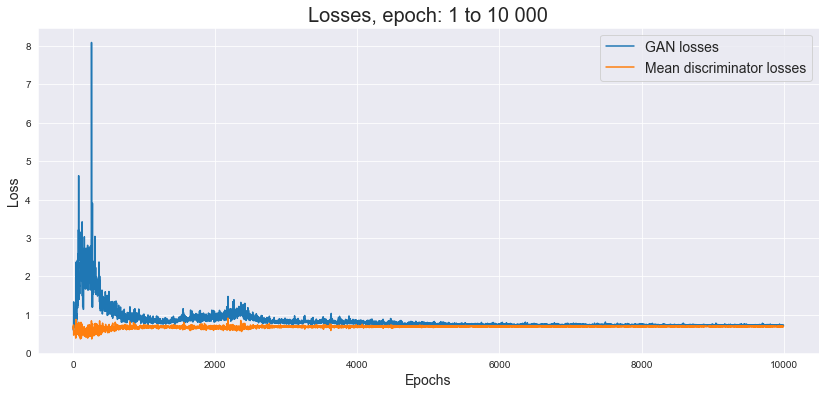

In [17]:
plt.figure(figsize=(14,6))
plt.plot(df['gan_loss'], label='GAN losses')
plt.plot(df['mean_disc_loss'], label='Mean discriminator losses')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc=1,prop={'size': 14})
plt.title('Losses, epoch: 1 to 10 000', fontsize=20)
plt.show()

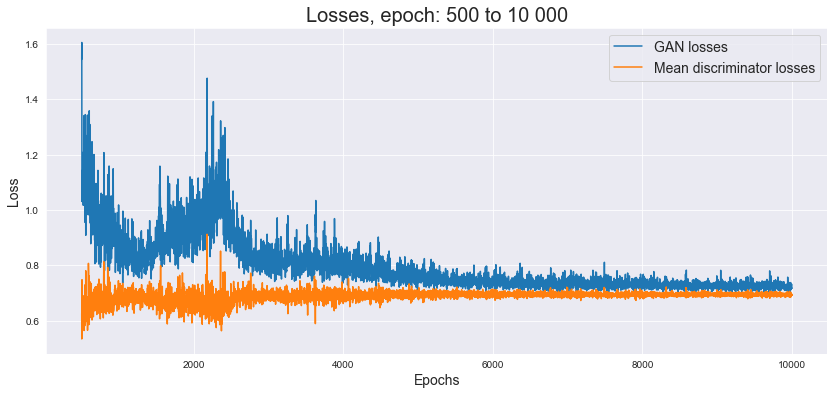

In [18]:
plt.figure(figsize=(14,6))
plt.plot(df['gan_loss'][500:], label='GAN losses')
plt.plot(df['mean_disc_loss'][500:], label='Mean discriminator losses')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc=1,prop={'size': 14})
plt.title('Losses, epoch: 500 to 10 000', fontsize=20)
plt.show()

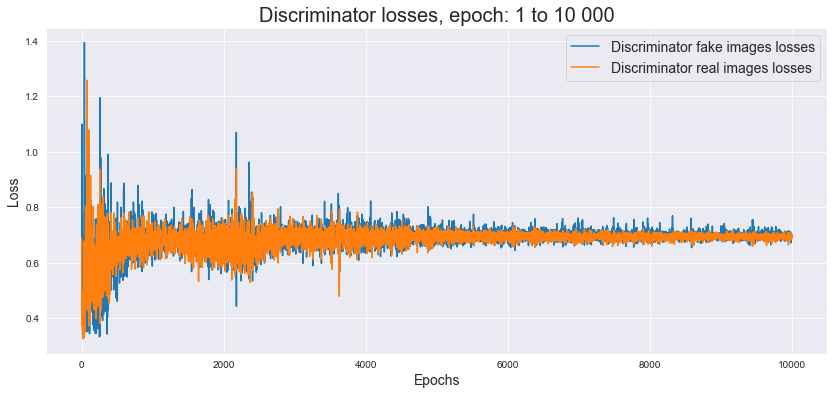

In [19]:
plt.figure(figsize=(14,6))
plt.plot(df['disc_fake_loss'], label='Discriminator fake images losses')
plt.plot(df['disc_real_loss'], label='Discriminator real images losses')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc=1,prop={'size': 14})
plt.title('Discriminator losses, epoch: 1 to 10 000', fontsize=20)
plt.show()

In [20]:
'''Creating a gif from our generated images''' 

frames = []
imgs = glob.glob(r"D:\projekt_output\Images1\*.png")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
frames[0].save(save_gif_dir + '\\png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=1)

Sample of real and generated images.

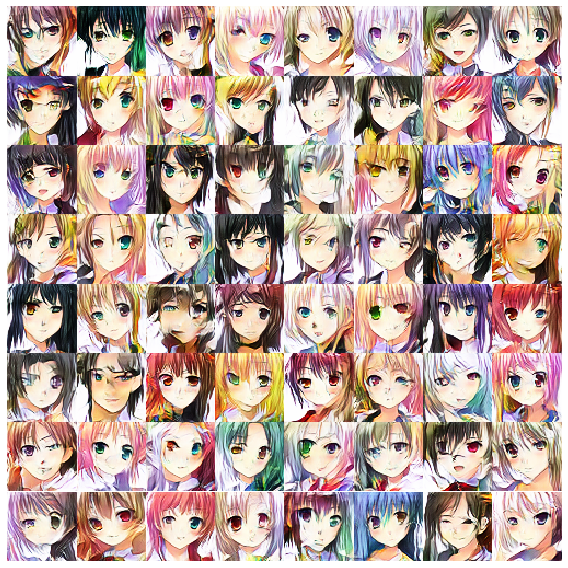

In [21]:
''' Generated images'''
plt.figure(figsize=(8, 8))
gs1 = gs.GridSpec(8, 8)
gs1.update(wspace=0, hspace=0)

random_indices = np.random.choice(fake_data_X.shape[0], 64, replace=False)
for i in range(64):
    ax1 = plt.subplot(gs1[i])
    ax1.set_aspect('equal')
    random_index = random_indices[i]
    image = fake_data_X[random_index, :, :, :]
    fig = plt.imshow(denorm_img(image))
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig(save_images_dir + str(epoch).zfill(5) + "_image.png", bbox_inches='tight', pad_inches=0)
plt.show()

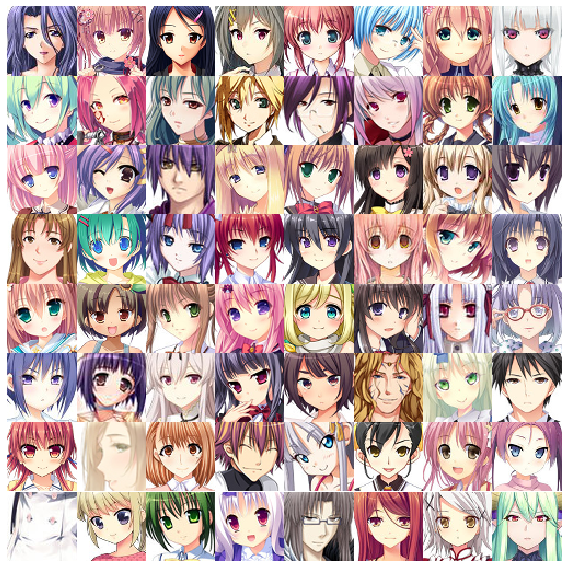

In [22]:
'''Real images'''
plt.figure(figsize=(8, 8))
gs1 = gs.GridSpec(8, 8)
gs1.update(wspace=0, hspace=0)

idx = np.random.randint(0, X.shape[0], batch_size)
real_data_X = X[idx]

for i in range(64):
    ax1 = plt.subplot(gs1[i])
    ax1.set_aspect('equal')
    random_index = random_indices[i]
    image = real_data_X[random_index, :, :, :]
    fig = plt.imshow(denorm_img(image))
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig(save_gif_dir + "real_image.png", bbox_inches='tight', pad_inches=0)
plt.show()

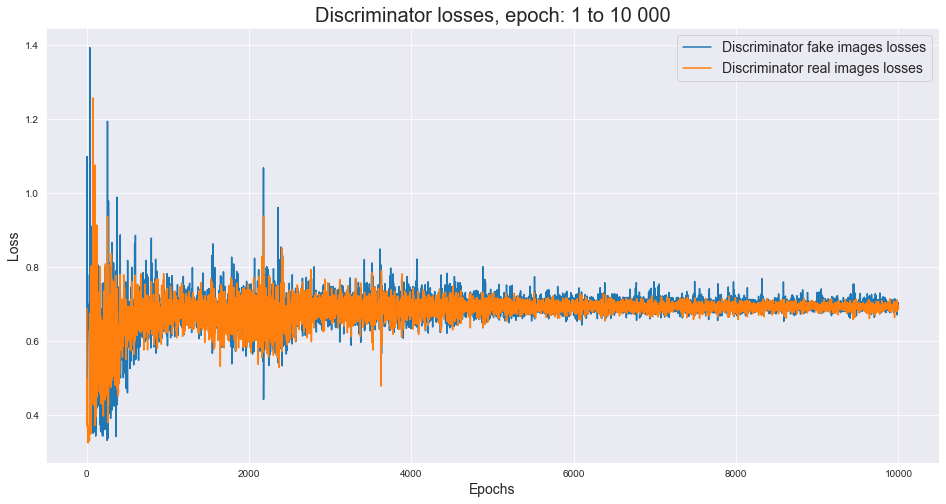

In [23]:
plt.figure(figsize=(16,8))
plt.plot(df['disc_fake_loss'], label='Discriminator fake images losses')
plt.plot(df['disc_real_loss'], label='Discriminator real images losses')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc=1,prop={'size': 14})
plt.title('Discriminator losses, epoch: 1 to 10 000', fontsize=20)
plt.show()

### Loading model weights from earlier epochs

In [18]:
models = []
model0 = load_model(save_model_dir+'499_GENERATOR.hdf5')
models.append(model0)
step = 999
for i in range(1,11):
    model = load_model(save_model_dir+f'{step}_GENERATOR.hdf5')
    models.append(model)
    step += 1000

In [40]:
list_generators = []
for i in range(11):
    z = models[i].predict(chosen_noise)
    list_generators.append(z)
    i +=1

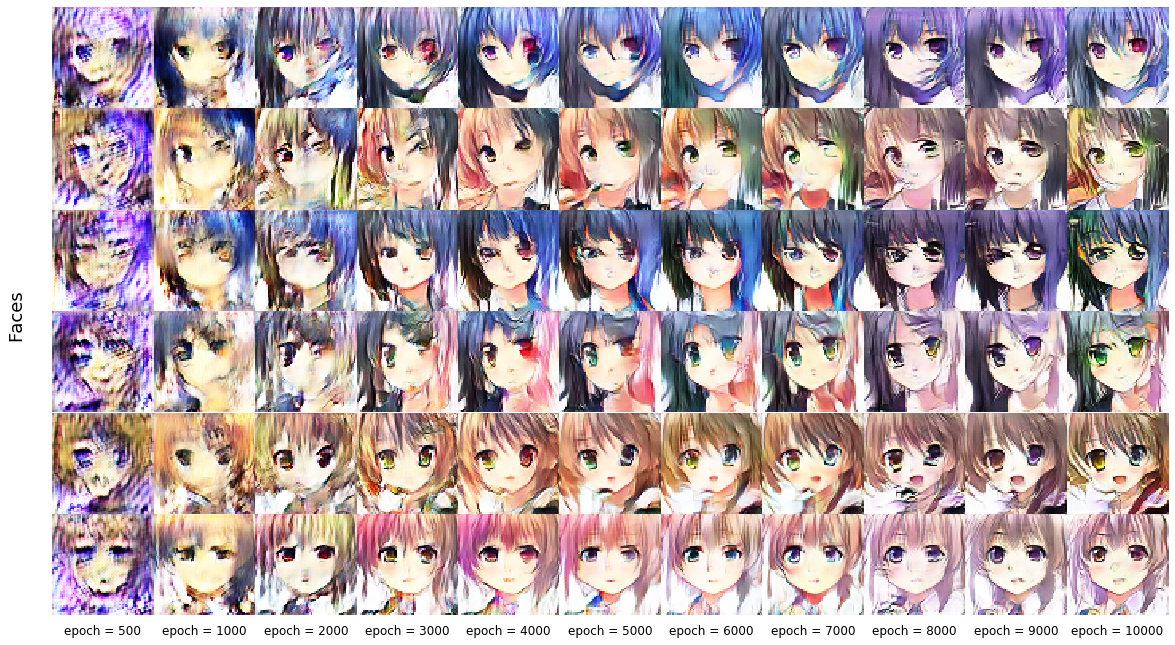

In [50]:
fig, axes = plt.subplots(6, 11, figsize=(20,20),
                         gridspec_kw={'hspace': -0.825, 'wspace': 0})
count = 3
for i in range(6):
    for j in range(11):
        image = list_generators[j][count, :, :, :]
        axes[i, j].imshow(denorm_img(image))
        axes[i, j].axis('off')
    
    count += 11
    
fig.text(0.1, 0.5, 'Faces', ha='center', va='center', rotation='vertical', fontsize=18)
    
step = 0
axes[5,0].set_title('epoch = 500', fontsize=12, x=0.5, y= -0.25)
for l in range(1, 11):
    axes[5,l].set_title(f'epoch = {step+1000}', fontsize=12, x=0.5, y= -0.25)
    step += 1000
plt.savefig(save_gif_dir + "process_of_training.png", bbox_inches='tight', pad_inches=0)
plt.show()